In [2]:
import torch
vers = torch.__version__
print("Torch vers: ", vers)

# PyG installation
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

import torch_geometric

Torch vers:  2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
from tqdm import tqdm
import copy as cp
import torch
from torch.utils.data import random_split
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch_geometric.datasets import UPFD
from torch_scatter import scatter_mean
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, DataListLoader
from torch_geometric.nn import DataParallel

In [4]:
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import accuracy_score, f1_score

GOSSIPCOP BI-GCN

In [24]:
train_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
test_data = UPFD(root=".", name="gossipcop", feature="content", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Train Samples:  1092
Test Samples:  3826


In [25]:
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()
    G.add_nodes_from(range(data.num_nodes))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []
    values = {}
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue
        G.add_edge(u, v)
        for key in edge_attrs:
            G[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return G

In [26]:
sample_id=1
train_data[sample_id].edge_index

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  15,  15,  17,  17,
          22,  22,  22,  22,  23,  26,  26,  26,  26,  26,  26,  26,  26,  27,
          27,  27,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  30,  34,  34,  38,  38,  38,
          38,  39,  40,  57,  59,  65,  65,  65,  66,  68,  69,  77,  77,  79,
          79,  80,  83,  83,  83,  83,  84, 101, 110, 115, 116, 117],
        [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  43,  44,
          45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  5

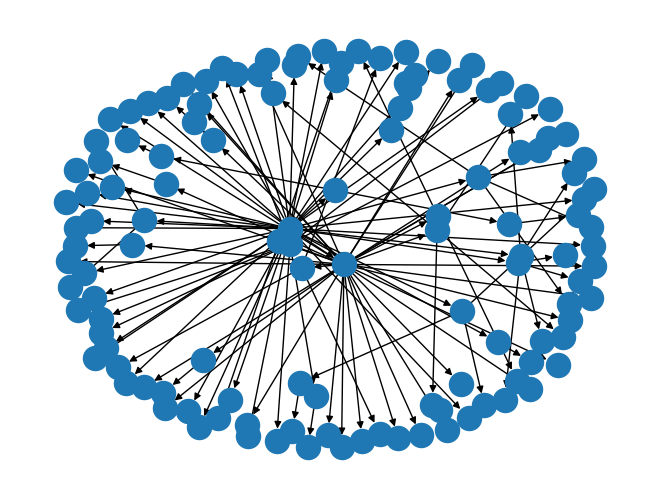

In [27]:
nx.draw(to_networkx(train_data[sample_id]))

In [28]:
print(train_data[sample_id].x.shape)
train_data[sample_id].x

torch.Size([125, 310])


tensor([[0.5220, 0.5120, 0.4817,  ..., 0.6874, 0.1023, 0.1529],
        [0.4610, 0.4544, 0.6279,  ..., 0.2055, 0.1667, 0.2500],
        [0.4461, 0.4728, 0.4978,  ..., 0.8356, 0.0556, 0.0000],
        ...,
        [0.5574, 0.4934, 0.5588,  ..., 0.3562, 0.0556, 0.2647],
        [0.5274, 0.5889, 0.4425,  ..., 0.9589, 0.1111, 0.1176],
        [0.5220, 0.5120, 0.4817,  ..., 0.6874, 0.1023, 0.1529]])

Text(0.5, 0, 'Class')

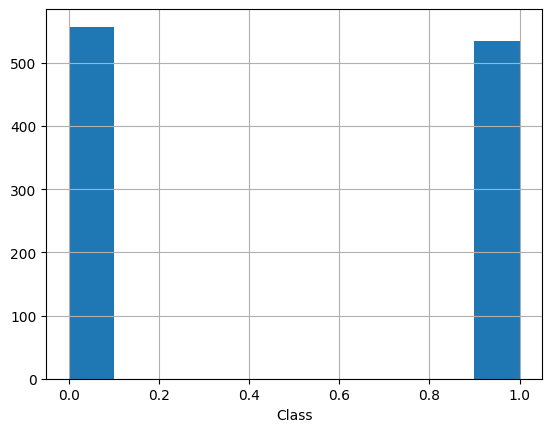

In [29]:
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()
plt.xlabel('Class')

In [30]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [31]:
class BiGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(BiGCN, self).__init__()
        self.conv1_td = GCNConv(in_channels, hidden_channels)
        self.conv2_td = GCNConv(hidden_channels, out_channels)
        self.conv1_bu = GCNConv(in_channels, hidden_channels)
        self.conv2_bu = GCNConv(hidden_channels, out_channels)
        self.fc = Linear(2*out_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Top-down propagation
        x_td = self.conv1_td(x, edge_index)
        x_td = torch.relu(x_td)
        x_td = self.conv2_td(x_td, edge_index)

        # Bottom-up propagation
        x_bu = self.conv1_bu(x, edge_index)
        x_bu = torch.relu(x_bu)
        x_bu = self.conv2_bu(x_bu, edge_index)

        # Concatenate top-down and bottom-up outputs
        x_concat = torch.cat((x_td, x_bu), dim=1)
        x_out = self.fc(x_concat)

        # Apply global mean pooling
        x_out = global_mean_pool(x_out, batch)

        return x_out

In [32]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Graph Convolutions
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = global_mean_pool(h, batch)

        # Readout
        h = self.lin0(h).relu()

        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [ 0, 14, 94, 171, 230, 302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()

        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

In [33]:
def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        out = torch.sigmoid(out)  # Apply sigmoid activation
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

        # calculate accuracy
        preds = torch.round(out)
        correct += preds.eq(data.y.view_as(preds)).sum().item()
        total_samples += data.num_graphs

    accuracy = correct / total_samples
    avg_loss = total_loss / len(train_loader.dataset)
    return avg_loss, accuracy

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        out = torch.sigmoid(out)  # Apply sigmoid activation
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        preds = torch.round(out).int()  # Round predictions to 0 or 1 and convert to integers
        correct += preds.eq(data.y.view_as(preds)).sum().item()
        total_samples += data.num_graphs
        all_preds.append(preds.cpu())  # Move predictions to CPU
        all_labels.append(data.y.int().cpu())  # Move labels to CPU and convert to integers

    # Calculate Metrics
    accuracy = correct / total_samples
    avg_loss = total_loss / len(test_loader.dataset)
    f1 = f1_score(torch.cat(all_preds), torch.cat(all_labels))  # Calculate F1 score
    return avg_loss, accuracy, f1

In [34]:
# GOSSIPCOP BI-GCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiGCN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

In [35]:
for epoch in range(40):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.4f} | '
          f'TestLoss: {test_loss:.4f} | TrainAcc: {train_acc:.4f} | TestAcc: {test_acc:.4f} | TestF1: {test_f1:.4f}')

Epoch: 00 |  TrainLoss: 1.0366 | TestLoss: 0.7379 | TrainAcc: 0.4945 | TestAcc: 0.4992 | TestF1: 0.0000
Epoch: 01 |  TrainLoss: 0.7009 | TestLoss: 0.6875 | TrainAcc: 0.5348 | TestAcc: 0.4992 | TestF1: 0.0000
Epoch: 02 |  TrainLoss: 0.6863 | TestLoss: 0.6863 | TrainAcc: 0.5284 | TestAcc: 0.4992 | TestF1: 0.0000
Epoch: 03 |  TrainLoss: 0.6858 | TestLoss: 0.6821 | TrainAcc: 0.5348 | TestAcc: 0.7891 | TestF1: 0.8230
Epoch: 04 |  TrainLoss: 0.6825 | TestLoss: 0.6831 | TrainAcc: 0.5925 | TestAcc: 0.5008 | TestF1: 0.6674
Epoch: 05 |  TrainLoss: 0.6796 | TestLoss: 0.6784 | TrainAcc: 0.6108 | TestAcc: 0.4992 | TestF1: 0.0000
Epoch: 06 |  TrainLoss: 0.6863 | TestLoss: 0.6904 | TrainAcc: 0.5504 | TestAcc: 0.4992 | TestF1: 0.0000
Epoch: 07 |  TrainLoss: 0.6825 | TestLoss: 0.6777 | TrainAcc: 0.5284 | TestAcc: 0.7569 | TestF1: 0.7177
Epoch: 08 |  TrainLoss: 0.6784 | TestLoss: 0.6762 | TrainAcc: 0.6227 | TestAcc: 0.8442 | TestF1: 0.8586
Epoch: 09 |  TrainLoss: 0.6750 | TestLoss: 0.6784 | TrainAcc: 0.

In [36]:
# GOSSIPCOP GCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

        # Calculate accuracy
        preds = torch.round(out)
        correct += preds.eq(data.y.view_as(preds)).sum().item()
        total_samples += data.num_graphs

    accuracy = correct / total_samples
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss, accuracy

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs

        # Calculate accuracy
        preds = torch.round(out)
        correct += preds.eq(data.y.view_as(preds)).sum().item()
        total_samples += data.num_graphs
        all_preds.append(preds)
        all_labels.append(data.y)

    accuracy = correct / total_samples
    avg_loss = total_loss / len(test_loader.dataset)

    # Calculate Metrics
    f1 = f1_score(torch.cat(all_preds), torch.cat(all_labels))

    return avg_loss, accuracy, f1

In [37]:
for epoch in range(40):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.4f} | '
          f'TestLoss: {test_loss:.4f} | TrainAcc: {train_acc:.4f} | TestAcc: {test_acc:.4f} | TestF1: {test_f1:.4f}')

Epoch: 00 |  TrainLoss: 0.7398 | TestLoss: 0.6965 | TrainAcc: 0.5027 | TestAcc: 0.5008 | TestF1: 0.6674
Epoch: 01 |  TrainLoss: 0.6925 | TestLoss: 0.7355 | TrainAcc: 0.5302 | TestAcc: 0.4992 | TestF1: 0.0000
Epoch: 02 |  TrainLoss: 0.6959 | TestLoss: 0.7257 | TrainAcc: 0.5211 | TestAcc: 0.4992 | TestF1: 0.0000
Epoch: 03 |  TrainLoss: 0.6959 | TestLoss: 0.6994 | TrainAcc: 0.5943 | TestAcc: 0.4992 | TestF1: 0.0000
Epoch: 04 |  TrainLoss: 0.6894 | TestLoss: 0.7341 | TrainAcc: 0.5339 | TestAcc: 0.4992 | TestF1: 0.0000
Epoch: 05 |  TrainLoss: 0.7054 | TestLoss: 0.7374 | TrainAcc: 0.4936 | TestAcc: 0.5008 | TestF1: 0.6674
Epoch: 06 |  TrainLoss: 0.6989 | TestLoss: 0.6878 | TrainAcc: 0.5201 | TestAcc: 0.4992 | TestF1: 0.0000
Epoch: 07 |  TrainLoss: 0.6988 | TestLoss: 0.7066 | TrainAcc: 0.4918 | TestAcc: 0.4992 | TestF1: 0.0000
Epoch: 08 |  TrainLoss: 0.6891 | TestLoss: 0.7548 | TrainAcc: 0.6777 | TestAcc: 0.4992 | TestF1: 0.0000
Epoch: 09 |  TrainLoss: 0.7027 | TestLoss: 0.7015 | TrainAcc: 0.

POLITIFACT

In [52]:
train_data = UPFD(root=".", name="politifact", feature="content", split="train")
test_data = UPFD(root=".", name="politifact", feature="content", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Train Samples:  62
Test Samples:  221


In [53]:
sample_id=1
train_data[sample_id].edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  3,  3,  5,  5,  7,  7,  7,  7,
          7,  7,  7,  9, 10, 12, 14, 21, 21, 21, 28, 29, 30],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 16, 17, 18, 19, 20, 21,
         22, 23, 24, 28, 13, 14, 15, 25, 26, 27, 29, 30, 31]])

In [54]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [57]:
# POLITIFACT BIGCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiGCN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        out = torch.sigmoid(out)  # Apply sigmoid activation
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

        # calculate accuracy
        preds = torch.round(out)
        correct += preds.eq(data.y.view_as(preds)).sum().item()
        total_samples += data.num_graphs

    accuracy = correct / total_samples
    avg_loss = total_loss / len(train_loader.dataset)
    return avg_loss, accuracy

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        out = torch.sigmoid(out)  # Apply sigmoid activation
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        preds = torch.round(out).int()  # Round predictions to 0 or 1 and convert to integers
        correct += preds.eq(data.y.view_as(preds)).sum().item()
        total_samples += data.num_graphs
        all_preds.append(preds.cpu())  # Move predictions to CPU
        all_labels.append(data.y.int().cpu())  # Move labels to CPU and convert to integers

    # Calculate Metrics
    accuracy = correct / total_samples
    avg_loss = total_loss / len(test_loader.dataset)
    f1 = f1_score(torch.cat(all_preds), torch.cat(all_labels))  # Calculate F1 score
    return avg_loss, accuracy, f1

In [59]:
for epoch in range(40):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.4f} | '
          f'TestLoss: {test_loss:.4f} | TrainAcc: {train_acc:.4f} | TestAcc: {test_acc:.4f} | TestF1: {test_f1:.4f}')

Epoch: 00 |  TrainLoss: 0.6421 | TestLoss: 0.6560 | TrainAcc: 0.5806 | TestAcc: 0.7557 | TestF1: 0.6932
Epoch: 01 |  TrainLoss: 0.6376 | TestLoss: 0.6822 | TrainAcc: 0.8387 | TestAcc: 0.4887 | TestF1: 0.0000
Epoch: 02 |  TrainLoss: 0.6317 | TestLoss: 0.6576 | TrainAcc: 0.5806 | TestAcc: 0.4887 | TestF1: 0.0000
Epoch: 03 |  TrainLoss: 0.6250 | TestLoss: 0.6572 | TrainAcc: 0.5968 | TestAcc: 0.4887 | TestF1: 0.0000
Epoch: 04 |  TrainLoss: 0.6205 | TestLoss: 0.6683 | TrainAcc: 0.5806 | TestAcc: 0.4887 | TestF1: 0.0000
Epoch: 05 |  TrainLoss: 0.6182 | TestLoss: 0.6391 | TrainAcc: 0.5806 | TestAcc: 0.8507 | TestF1: 0.8619
Epoch: 06 |  TrainLoss: 0.6248 | TestLoss: 0.7305 | TrainAcc: 0.9032 | TestAcc: 0.4887 | TestF1: 0.0000
Epoch: 07 |  TrainLoss: 0.6469 | TestLoss: 0.6353 | TrainAcc: 0.5806 | TestAcc: 0.7149 | TestF1: 0.7758
Epoch: 08 |  TrainLoss: 0.6304 | TestLoss: 0.6496 | TrainAcc: 0.7419 | TestAcc: 0.4887 | TestF1: 0.0000
Epoch: 09 |  TrainLoss: 0.6041 | TestLoss: 0.6854 | TrainAcc: 0.

POLITIFACT GCN

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

        # Calculate accuracy
        preds = torch.round(out)
        correct += preds.eq(data.y.view_as(preds)).sum().item()
        total_samples += data.num_graphs

    accuracy = correct / total_samples
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss, accuracy

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs

        # Calculate accuracy
        preds = torch.round(out)
        correct += preds.eq(data.y.view_as(preds)).sum().item()
        total_samples += data.num_graphs
        all_preds.append(preds)
        all_labels.append(data.y)

    accuracy = correct / total_samples
    avg_loss = total_loss / len(test_loader.dataset)

    # Calculate Metrics
    f1 = f1_score(torch.cat(all_preds), torch.cat(all_labels))

    return avg_loss, accuracy, f1


In [61]:
for epoch in range(40):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.4f} | '
          f'TestLoss: {test_loss:.4f} | TrainAcc: {train_acc:.4f} | TestAcc: {test_acc:.4f} | TestF1: {test_f1:.4f}')

Epoch: 00 |  TrainLoss: 0.6989 | TestLoss: 1.5184 | TrainAcc: 0.4194 | TestAcc: 0.4887 | TestF1: 0.0000
Epoch: 01 |  TrainLoss: 1.2545 | TestLoss: 0.7632 | TrainAcc: 0.5806 | TestAcc: 0.4887 | TestF1: 0.0000
Epoch: 02 |  TrainLoss: 0.6964 | TestLoss: 0.7449 | TrainAcc: 0.5806 | TestAcc: 0.5113 | TestF1: 0.6766
Epoch: 03 |  TrainLoss: 0.8087 | TestLoss: 0.7072 | TrainAcc: 0.4194 | TestAcc: 0.5113 | TestF1: 0.6766
Epoch: 04 |  TrainLoss: 0.7430 | TestLoss: 0.6926 | TrainAcc: 0.4194 | TestAcc: 0.4887 | TestF1: 0.0000
Epoch: 05 |  TrainLoss: 0.6916 | TestLoss: 0.7249 | TrainAcc: 0.5806 | TestAcc: 0.4887 | TestF1: 0.0000
Epoch: 06 |  TrainLoss: 0.6819 | TestLoss: 0.7523 | TrainAcc: 0.5806 | TestAcc: 0.4887 | TestF1: 0.0000
Epoch: 07 |  TrainLoss: 0.6921 | TestLoss: 0.7242 | TrainAcc: 0.5806 | TestAcc: 0.4887 | TestF1: 0.0000
Epoch: 08 |  TrainLoss: 0.6815 | TestLoss: 0.6985 | TrainAcc: 0.5806 | TestAcc: 0.4887 | TestF1: 0.0000
Epoch: 09 |  TrainLoss: 0.6818 | TestLoss: 0.7004 | TrainAcc: 0.